In [1]:
import sys
sys.path.append('..')
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from nt_toolbox.signal import gaussian_blur, imageplot, load_image
from nt_toolbox.perform_blurring import perform_blurring
from nt_toolbox.general import rescale
from plotting_tools import cplot
from numeric_tools import compute_gradient, planar_curve, resample
from active_contours import perform_gradient_descent_standard_curve, perform_gradient_descent_polar_curve
from skimage import transform
from nt_toolbox.perform_redistancing import *
import scipy
import warnings
warnings.filterwarnings('ignore')

In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import FloatSlider, Checkbox, IntSlider


### Loading image

In [3]:
def display_image(sigma):
    global W
    global n
    n =200
    f0 = load_image('data/disk_biz.bmp', resc=1)
    f0 = transform.resize(f0/765, [n, n], 1)
    W = gaussian_blur(f0,3.0)
    W = rescale( np.minimum(W,.05), .3,1)
    noise = np.random.normal(0, sigma, n*n).reshape(n,n )
    W = W + noise
    imageplot(W)

<IPython.core.display.Javascript object>


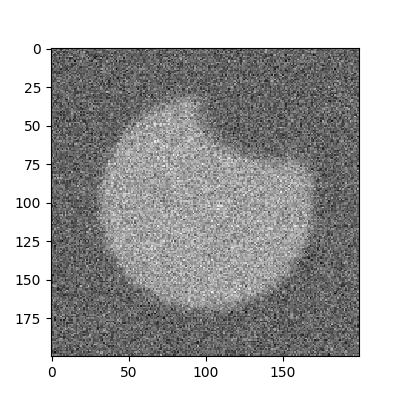

interactive(children=(FloatSlider(value=0.2, description='sigma', max=1.0), Output()), _dom_classes=('widget-i…

In [4]:
plt.figure(figsize=(4,4))
interact(display_image, sigma=FloatSlider(min=0, max=1, step=0.1, value=0.2));


#### Initialisation des contours

<IPython.core.display.Javascript object>


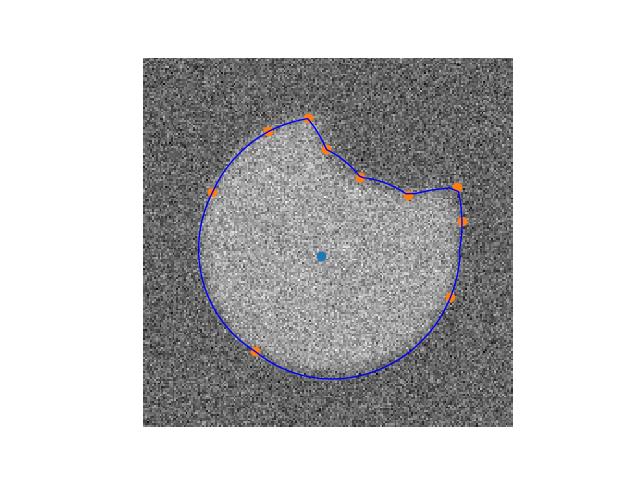

In [70]:
%matplotlib notebook
fig, ax = plt.subplots()
ax.set_xlim(xmin=0, xmax=n)
ax.set_ylim(ymin=n, ymax=0)
contour = []
c0 = n/2 +n/2*1j
thetas = []
imageplot(W)
ax.autoscale(enable=False,  tight=True)

def onclick(event):
    global c0
    global contour
    
    fig.clear()
    imageplot(W)
    plt.scatter(np.real(c0), np.imag(c0))
    contour.append(event.xdata +1j*event.ydata)
    plt.scatter(np.real(contour), np.imag(contour))
    c_r = np.sqrt(np.real(contour - c0)**2 + np.imag(contour - c0)**2)
    
    thetas.append(np.mod(np.angle(event.xdata+1j*event.ydata-c0), 2*np.pi))
    #c_r = np.concatenate((c_r, np.array([c_r[0]])))

    cr = scipy.interpolate.interp1d(thetas, np.array(c_r), kind='linear', fill_value='extrapolate')
    theta = np.transpose(np.linspace(0, 2 * np.pi, 128 + 1))
    theta = theta[0:-1]

    cplot(planar_curve(c0, cr(theta), theta).T)
    
def onpress(event):

    global c0
    c0 = event.xdata +1j*event.ydata
    plt.scatter(np.real(c0), np.imag(c0))

      
cid = fig.canvas.mpl_connect('button_press_event', onclick)
cad = fig.canvas.mpl_connect('key_press_event', onpress)



In [71]:
c_r = np.sqrt(np.real(contour - c0)**2 + np.imag(contour - c0)**2)
#c_r[-1] = c_r[0]
cr = scipy.interpolate.interp1d(thetas, np.array(c_r), kind='linear', fill_value='extrapolate')
theta = np.transpose(np.linspace(0, 2 * np.pi, 128 + 1))
theta = theta[0:-1]
c_r_init = np.flip(cr(np.mod(theta+np.pi/2, 2*np.pi)))
c_0_init = np.imag(c0) + 1j*(np.real(c0))

In [72]:
lam = 1
gamma = 0.042
sobolev = True
n_iter=5000

In [73]:
def interaction_display(lam_set, gamma_set, sobolev_set, n_iter_set):
    global lam 
    lam = lam_set
    global gamma
    gamma = gamma_set
    global sobolev
    sobolev = sobolev_set
    global n_iter 
    n_iter = n_iter_set

### Setting parameters

In [74]:
interact(interaction_display, lam_set=FloatSlider(min=0.1, max=10, step=0.1, value=1),
                              gamma_set=FloatSlider(min=0.042, max=100, step=0.1),
                              n_iter_set=IntSlider(min=1, max=15000, step=500,value=5000),
                              sobolev_set=Checkbox(True))


interactive(children=(FloatSlider(value=1.0, description='lam_set', max=10.0, min=0.1), FloatSlider(value=0.04…

<function __main__.interaction_display(lam_set, gamma_set, sobolev_set, n_iter_set)>

<IPython.core.display.Javascript object>


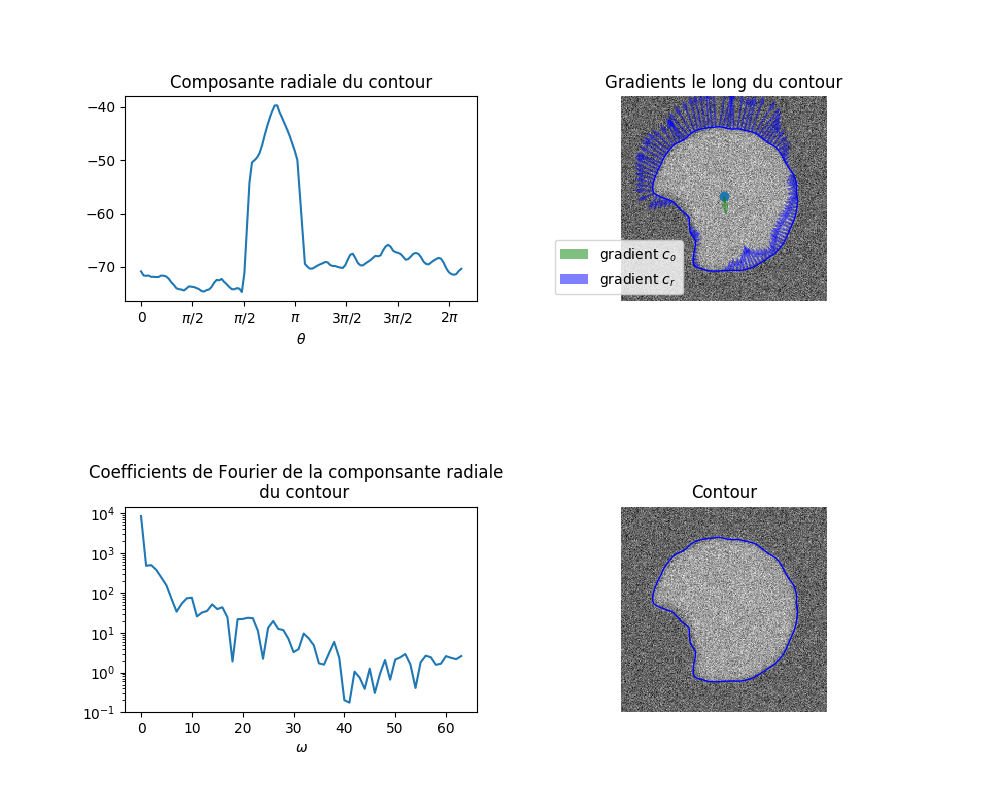

In [75]:
c0_new, cr_new = perform_gradient_descent_polar_curve(W,
                                     c_0_init,
                                     c_r_init,
                                     dt=1,
                                     niter=n_iter,
                                     nb_points_c=128,
                                     sobolev=sobolev,
                                     lam=lam,
                                     gamma=gamma,
                                     region_term=W,
                                     c1=1,
                                     c2=0,
                                     step_display=1000)

<IPython.core.display.Javascript object>


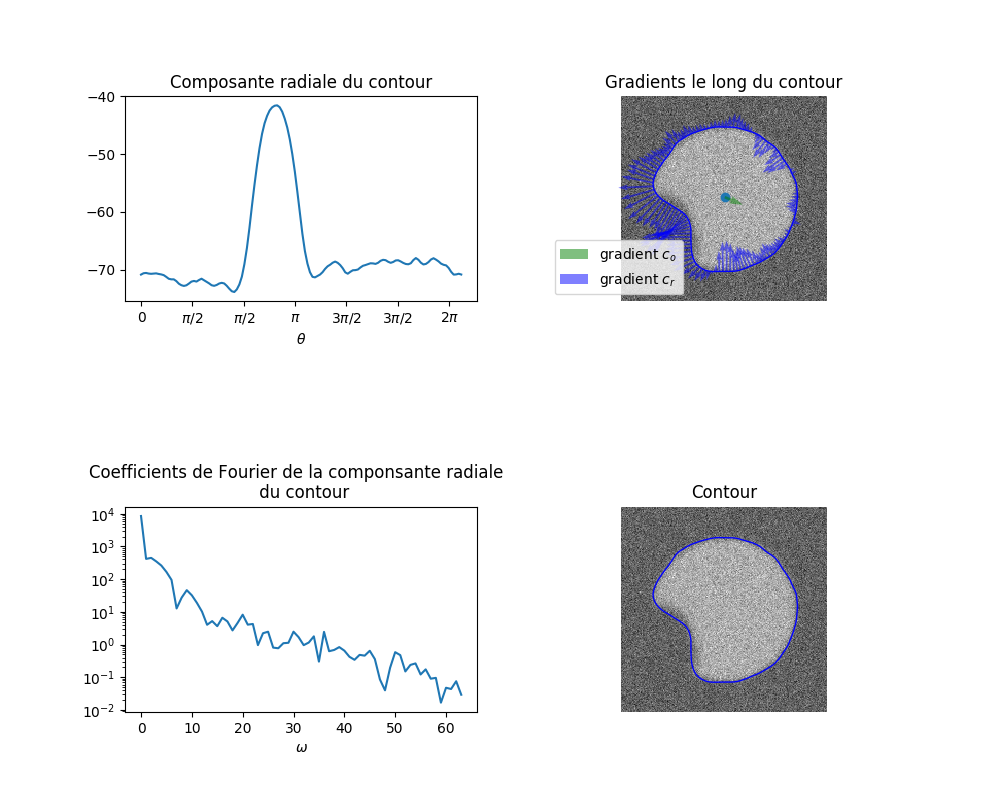

In [29]:
c_0 = n/2 * (2/3 + 1j)

c0_new, cr_new = perform_gradient_descent_polar_curve(W,
                                     c_0,
                                     cr_new,
                                     dt=1,
                                     niter=n_iter,
                                     nb_points_c=128,
                                     sobolev=sobolev,
                                     lam=lam,
                                     gamma=gamma,
                                     region_term=W,
                                     c1=1,
                                     c2=0,
                                     step_display=1000)